# **SimPer Tutorial**

In this notebook, we provide a hands-on tutorial for SimPer on the [RotatingDigits dataset](https://arxiv.org/pdf/2210.03115.pdf), as a quick overview on how to perform practical self-supervised learning with SimPer on custom periodic learning datasets.

## Dependencies Setup

In [1]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 38.0 MB/s eta 0:00:00


In [4]:
import os
import numpy as np
import h5py
import subprocess
import glob
import warnings
import time
import matplotlib.pyplot as plt
from os.path import join
from typing import Optional, Tuple, Any, Callable, Dict, List, Text

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import tensorflow_addons as tfa

from tensorflow.keras.layers import Conv2D, Conv3D, Dense, Lambda, BatchNormalization, GlobalAveragePooling2D, Flatten, Dropout, Embedding, TimeDistributed, MaxPool2D, AvgPool2D
from tensorflow_addons.layers import GroupNormalization

## Dataset

Define constants

In [5]:
# dataset + training
_MAX_FREQ = 5
_MIN_FREQ = 0.5

IMG_SIZE = 28
CHANNELS = 1
_FPS = 30
_LEGNTH_SEC = 5
NUM_FRAMES = _FPS * _LEGNTH_SEC

# SSL related
MAX_SPEED = 3
NUM_SELF_CON_SIMPER = 10
SSL_FRAMES = NUM_FRAMES // MAX_SPEED

# experiment settings
max_train, max_test = 100, 200
dataset_type = 'cls_0123456789'
RANDOM_PHASE = True
SIMPER_BATCH_SIZE = 4
SUP_BATCH_SIZE = 16

Creating RotatingDigits dataset

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
MNIST:
	train: 1000
	test: 2000
[2.9696608, 3.718352, 3.2124352, 2.9519744, 2.4064467, 3.4065235, 2.4691424, 4.5129786, 4.8364825, 2.2254868, 4.0627627, 2.880027, 3.0562005, 4.665185, 0.8196623, 0.89208186, 0.5909828, 4.2467895, 4.001705, 4.415055, 4.9037824, 4.0962133, 2.576657, 4.012381, 1.0322349, 3.3796446, 1.1450897, 4.75101, 2.8483174, 2.3659787, 1.6905003, 3.9840517, 2.5526764, 3.057953, 0.5845541, 3.2793598, 3.2544308, 3.276203, 4.746866, 3.5681913, 2.1177855, 2.4666438, 3.6393404, 0.77101463, 3.5004501, 3.5178704, 1.4467216, 1.0801684, 1.9194276, 2.1366985, 3.0658855, 2.4737067, 4.9476824, 0.95920163, 1.4399455, 1.2258928, 3.4389875, 1.6398122, 2.5983984, 1.5999151, 1.2153631, 0.9966881, 3.453483, 1.1218233, 1.3846207, 2.1592634, 4.1944695, 0.93695575, 4.270752, 0.93244284, 4.894068, 2.6089303, 4.895425, 3.2218049, 3.8266861, 0.67634505, 1.7726313, 1.0408845, 

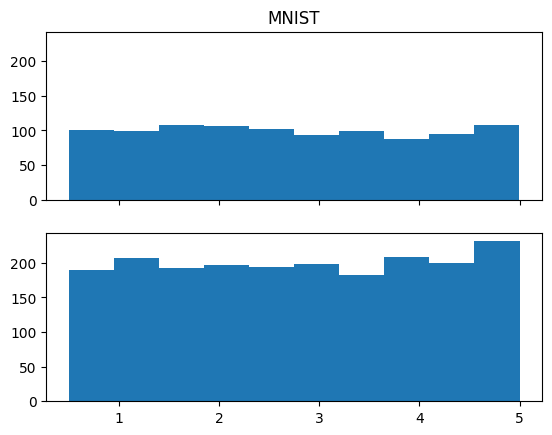

In [6]:
def get_img_num_per_cls(cls_num, img_max, imb_type, imb_factor=1):
  img_num_per_cls = []
  if 'exp' in imb_type:
    for cls_idx in range(cls_num):
      num = img_max * (imb_factor**(cls_idx / (cls_num - 1.)))
      img_num_per_cls.append(int(num))
  elif 'step' in imb_type:
    for cls_idx in range(cls_num // 2):
      img_num_per_cls.append(int(img_max))
    for cls_idx in range(cls_num // 2):
      img_num_per_cls.append(int(img_max * imb_factor))
  elif 'cls' in imb_type:
    selected_cls = [int(x) for x in imb_type.split('_')[-1]]
    for i in range(cls_num):
      if i in selected_cls:
        img_num_per_cls.append(img_max)
      else:
        img_num_per_cls.append(0)
  else:
    img_num_per_cls.extend([int(img_max)] * cls_num)
  if 'inv' in imb_type:
    img_num_per_cls = img_num_per_cls[::-1]
  return img_num_per_cls


def gen_imbalanced_data(images, labels, img_num_per_cls):
  new_images, new_labels = [], []
  labels_np = np.array(labels, dtype=np.int64)
  classes = np.unique(labels_np)
  num_per_cls_dict = dict()
  for the_class, the_img_num in zip(classes, img_num_per_cls):
    num_per_cls_dict[the_class] = the_img_num
    idx = np.where(labels_np == the_class)[0]
    np.random.shuffle(idx)
    select_idx = idx[:the_img_num]
    new_images.append(images[select_idx, ...])
    new_labels.append(labels[select_idx])
  new_images = tf.concat(new_images, axis=0)
  new_labels = tf.concat(new_labels, axis=0)
  return new_images, new_labels


# MNIST
mnist_train_x, mnist_train_y = tfds.as_numpy(tfds.load('mnist', split='train', batch_size=-1, as_supervised=True))
mnist_test_x, mnist_test_y = tfds.as_numpy(tfds.load('mnist', split='test', batch_size=-1, as_supervised=True))

img_per_cls_train = get_img_num_per_cls(cls_num=10, img_max=max_train, imb_type=dataset_type)
img_per_cls_test = get_img_num_per_cls(cls_num=10, img_max=max_test, imb_type=dataset_type)

# new sampled dataset
mnist_train_x, mnist_train_y = gen_imbalanced_data(mnist_train_x, mnist_train_y, img_per_cls_train)
mnist_test_x, mnist_test_y = gen_imbalanced_data(mnist_test_x, mnist_test_y, img_per_cls_test)

# random generate frequency labels
np.random.seed(0)
new_train_y = np.random.uniform(_MIN_FREQ, _MAX_FREQ, mnist_train_y.shape).astype('float32')
new_test_y = np.random.uniform(_MIN_FREQ, _MAX_FREQ, mnist_test_y.shape).astype('float32')

mnist_train = tf.data.Dataset.from_tensor_slices((
    mnist_train_x, {'freq': new_train_y, 'angle': new_train_y, 'class': mnist_train_y}))
mnist_test = tf.data.Dataset.from_tensor_slices((
    mnist_test_x, {'freq': new_test_y, 'angle': new_test_y, 'class': mnist_test_y}))

# dataset statistics + visualization
print(f"MNIST:\n\ttrain: {len(mnist_train)}\n\ttest: {len(mnist_test)}")
mnist_train_labels = [y['freq'].numpy() for _, y in mnist_train]
mnist_test_labels = [y['freq'].numpy() for _, y in mnist_test]
print(f"{mnist_train_labels}\n{mnist_test_labels}")

_, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].hist(mnist_train_labels)
ax[1].hist(mnist_test_labels)
ax[0].set_title("MNIST")
plt.show()

In [7]:
def rescale(x, y):
  x = tf.cast(x, tf.float32)
  x = (x / 255.0)
  return x, y


def clip_value(x, y):
  x = tf.clip_by_value(x, 0, 1)
  return x, y


def create_rotating_samples(x, y):
  if RANDOM_PHASE:
    offset = tf.random.uniform(
        (), minval=-1.57, maxval=1.57, dtype=tf.float32)
  else:
    offset = tf.constant(0, dtype=tf.float32)
  angles = [90. * tf.math.sin(2 * np.pi * y['freq'] * idx / _FPS + offset) for idx in range(NUM_FRAMES)]
  new_x = []
  for i in range(NUM_FRAMES):
    new_x.append(tfa.image.rotate(x, angles[i] * np.pi / 180.))
  y['angle'] = tf.stack(angles) * 3.14 / 180.
  return tf.stack(new_x), y


def transform(ds: tf.data.Dataset, repeat=True, training=True):
  ds = ds.map(rescale, num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.map(create_rotating_samples, num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.map(clip_value)
  return ds


mnist_train = transform(mnist_train, True, True)
mnist_test = transform(mnist_test, True, False)

for x, y in mnist_train.take(1):
  print(x.shape, y['freq'].shape, y['angle'].shape)

(150, 28, 28, 1) () (150,)


## SimPer: Augmentations (Periodicity-Variant & Invariant)

In [9]:
def random_apply(func, p, x):
  return tf.cond(
      tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
              tf.cast(p, tf.float32)),
      lambda: func(x),
      lambda: x)


def resize_and_rescale(x, y):
  x = tf.cast(x, tf.float32)
  x = tf.image.resize(x, [IMG_SIZE, IMG_SIZE])
  return x, y


def _sample_or_pad_sequence_indices(sequence: tf.Tensor, num_steps: int,
                                    stride: int,
                                    offset: tf.Tensor) -> tf.Tensor:
  sequence_length = tf.shape(sequence)[0]
  sel_idx = tf.range(sequence_length)

  # Repeats sequence until num_steps are available in total.
  max_length = num_steps * stride + offset
  num_repeats = tf.math.floordiv(max_length + sequence_length - 1,
                                 sequence_length)
  sel_idx = tf.tile(sel_idx, [num_repeats])

  steps = tf.range(offset, offset + num_steps * stride, stride)
  return tf.gather(sel_idx, steps)


def sample_sequence(sequence: tf.Tensor,
                    num_steps: int,
                    random: bool = True,
                    stride: int = 1,
                    seed: Optional[int] = None) -> tf.Tensor:
  sequence_length = tf.shape(sequence)[0]

  if random:
    sequence_length = tf.cast(sequence_length, tf.float32)
    frame_stride = tf.cast(stride, tf.float32)
    max_offset = tf.cond(
        sequence_length > (num_steps - 1) * frame_stride,
        lambda: sequence_length - (num_steps - 1) * frame_stride,
        lambda: sequence_length)
    offset = tf.random.uniform((),
                               maxval=tf.cast(max_offset, dtype=tf.int32),
                               dtype=tf.int32,
                               seed=seed)
  else:
    raise NotImplementedError(f"Only `random == True` is supported now.")
    offset = (sequence_length - num_steps * stride) // 2
    offset = tf.maximum(0, offset)

  indices = _sample_or_pad_sequence_indices(
      sequence=sequence, num_steps=num_steps, stride=stride, offset=offset)
  indices.set_shape((num_steps,))

  return tf.gather(sequence, indices)


def random_crop_resize(frames: tf.Tensor,
                       output_h: int = IMG_SIZE,
                       output_w: int = IMG_SIZE,
                       aspect_ratio: Tuple[float, float] = (0.75, 1.33),
                       area_range: Tuple[float, float] = (0.5, 1)) -> tf.Tensor:
  shape = tf.shape(frames)
  seq_len, _, _, channels = shape[0], shape[1], shape[2], shape[3]
  bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
  factor = output_w / output_h
  aspect_ratio = (aspect_ratio[0] * factor, aspect_ratio[1] * factor)
  sample_distorted_bbox = tf.image.sample_distorted_bounding_box(
      shape[1:],
      bounding_boxes=bbox,
      min_object_covered=0.1,
      aspect_ratio_range=aspect_ratio,
      area_range=area_range,
      max_attempts=100,
      use_image_if_no_bounding_boxes=True)
  bbox_begin, bbox_size, _ = sample_distorted_bbox
  offset_y, offset_x, _ = tf.unstack(bbox_begin)
  target_height, target_width, _ = tf.unstack(bbox_size)
  size = tf.convert_to_tensor((seq_len, target_height, target_width, channels))
  offset = tf.convert_to_tensor((0, offset_y, offset_x, 0))
  frames = tf.slice(frames, offset, size)
  frames = tf.cast(tf.image.resize(frames, (output_h, output_w)), frames.dtype)
  return frames


def gaussian_blur(image, kernel_size, sigma, padding='SAME'):
  radius = tf.cast(kernel_size / 2, dtype=tf.int32)
  kernel_size = radius * 2 + 1
  x = tf.cast(tf.range(-radius, radius + 1), dtype=tf.float32)
  blur_filter = tf.exp(
      -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.cast(sigma, dtype=tf.float32), 2.0)))
  blur_filter /= tf.reduce_sum(blur_filter)
  # One vertical and one horizontal filter.
  blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
  blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
  num_channels = tf.shape(image)[-1]
  blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
  blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
  expand_batch_dim = image.shape.ndims == 3
  if expand_batch_dim:
    image = tf.expand_dims(image, axis=0)
  blurred = tf.nn.depthwise_conv2d(
      image, blur_h, strides=[1, 1, 1, 1], padding=padding)
  blurred = tf.nn.depthwise_conv2d(
      blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
  if expand_batch_dim:
    blurred = tf.squeeze(blurred, axis=0)
  return blurred


def random_blur(image, height=IMG_SIZE, p=0.2):
  def _transform(image):
    sigma = tf.random.uniform([], 0.1, 2.0, dtype=tf.float32)
    return gaussian_blur(
        image, kernel_size=height//20, sigma=sigma, padding='SAME')
  return random_apply(_transform, p=p, x=image)


def random_flip_left_right(frames: tf.Tensor, seed: Optional[int] = None) -> tf.Tensor:
  is_flipped = tf.random.uniform((), minval=0, maxval=2, dtype=tf.int32, seed=seed)
  frames = tf.cond(
      tf.equal(is_flipped, 1),
      true_fn=lambda: tf.image.flip_left_right(frames),
      false_fn=lambda: frames)
  return frames


def random_flip_up_down(frames: tf.Tensor, seed: Optional[int] = None) -> tf.Tensor:
  is_flipped = tf.random.uniform((), minval=0, maxval=2, dtype=tf.int32, seed=seed)
  frames = tf.cond(
      tf.equal(is_flipped, 1),
      true_fn=lambda: tf.image.flip_up_down(frames),
      false_fn=lambda: frames)
  return frames


def random_rotation(frames: tf.Tensor, seed: Optional[int] = None) -> tf.Tensor:
  is_flipped = tf.random.uniform((), minval=0, maxval=2, dtype=tf.int32, seed=seed)
  frames = tf.cond(
      tf.equal(is_flipped, 1),
      true_fn=lambda: tf.image.rot90(frames),
      false_fn=lambda: frames)
  return frames


def to_grayscale(image, keep_channels=True):
  image = tf.image.rgb_to_grayscale(image)
  if keep_channels:
    image = tf.tile(image, [1, 1, 3])
  return image


def random_grayscale_3d(frames, p=0.2):
  num_frames, width, height, channels = frames.shape.as_list()
  big_image = tf.reshape(frames, [num_frames*width, height, channels])
  big_image = random_apply(to_grayscale, p=p, x=big_image)
  return tf.reshape(big_image, [num_frames, width, height, channels])


def random_brightness(image, max_delta=0.3):
  factor = tf.random.uniform(
      [], tf.maximum(1.0 - max_delta, 0), 1.0 + max_delta)
  image = image * factor
  return image


def random_reverse(frames: tf.Tensor, seed: Optional[int] = None) -> tf.Tensor:
  is_flipped = tf.random.uniform((), minval=0, maxval=2, dtype=tf.int32, seed=seed)
  frames = tf.cond(
      tf.equal(is_flipped, 1),
      true_fn=lambda: tf.experimental.numpy.flip(frames, axis=0),
      false_fn=lambda: frames)
  return frames

In [10]:
def arbitrary_speed_subsample(frames_speed,
                              num_steps: int = SSL_FRAMES,
                              random: bool = True,
                              stride: int = 1,
                              seed: Optional[int] = None) -> tf.Tensor:
  frames, speed = frames_speed
  frame_len = tf.cast(tf.shape(frames)[0], tf.float32)
  max_frame_len = tf.math.floordiv(frame_len, speed) if speed > 1 else frame_len

  x_ref = tf.range(0, speed * (len(frames) - 0.5), speed, dtype=tf.float32)
  x_ref = tf.stack([x_ref] * (IMG_SIZE * IMG_SIZE * CHANNELS))
  new_frames = tfp.math.batch_interp_regular_1d_grid(
      x=x_ref,
      x_ref_min=[0] * (IMG_SIZE * IMG_SIZE * CHANNELS),
      x_ref_max=[len(frames)] * (IMG_SIZE * IMG_SIZE * CHANNELS),
      y_ref=tf.transpose(tf.reshape(frames, [len(frames), -1]))
  )
  sequence = tf.reshape(
      tf.transpose(new_frames), frames.shape.as_list()
      )[:tf.cast(max_frame_len, tf.int32)]

  sequence_length = tf.shape(sequence)[0]

  if random:
    sequence_length = tf.cast(sequence_length, tf.float32)
    frame_stride = tf.cast(stride, tf.float32)
    max_offset = tf.cond(
        sequence_length > (num_steps - 1) * frame_stride,
        lambda: sequence_length - (num_steps - 1) * frame_stride,
        lambda: sequence_length)
    offset = tf.random.uniform((),
                               maxval=tf.cast(max_offset, dtype=tf.int32),
                               dtype=tf.int32,
                               seed=seed)
  else:
    raise NotImplementedError(f"Only `random == True` is supported now.")
    offset = (sequence_length - num_steps * stride) // 2
    offset = tf.maximum(0, offset)

  indices = _sample_or_pad_sequence_indices(
      sequence=sequence, num_steps=num_steps, stride=stride, offset=offset)
  indices.set_shape((num_steps,))

  return tf.gather(sequence, indices)


def batched_arbitrary_speed(
    frames, num_diff_speeds=NUM_SELF_CON_SIMPER, speed_range=(0.5, MAX_SPEED)):
  random_speeds = tf.random.uniform([num_diff_speeds],
                                    minval=speed_range[0],
                                    maxval=speed_range[1],
                                    dtype=tf.float32)
  random_speeds = tf.sort(random_speeds)
  random_speeds = tf.concat([random_speeds, random_speeds], 0)

  # construct (2 * M) sub-video batch for SimPER loss
  batched_frames = tf.stack([frames] * num_diff_speeds * 2)
  batched_frames = tf.map_fn(
      arbitrary_speed_subsample, (batched_frames, random_speeds),
      fn_output_signature=tf.float32)

  return batched_frames, random_speeds


@tf.function
def transform_simper(x, y):
  # step 1: temporal variant augmentation
  x, speeds = batched_arbitrary_speed(x)
  x = tf.map_fn(random_reverse, x, dtype=tf.float32,
                parallel_iterations=2 * NUM_SELF_CON_SIMPER)
  # step 2: spatial temporal invariant augmentation
  x = tf.map_fn(random_crop_resize, x, dtype=tf.float32,
                parallel_iterations=2 * NUM_SELF_CON_SIMPER)
  x = tf.map_fn(random_brightness, x, dtype=tf.float32,
                parallel_iterations=2 * NUM_SELF_CON_SIMPER)
  x = tf.map_fn(random_blur, x, dtype=tf.float32,
                parallel_iterations=2 * NUM_SELF_CON_SIMPER)
  x = tf.map_fn(random_flip_left_right, x, dtype=tf.float32,
                parallel_iterations=2 * NUM_SELF_CON_SIMPER)
  x = tf.clip_by_value(x, 0, 1)
  return x, speeds

In [11]:
def get_simper_dataloader(ds, shuffle_size=60000, batch_size=32, train=True):
  ds = ds.map(transform_simper, num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.cache()
  if train:
    ds = ds.shuffle(buffer_size=shuffle_size)
  ds = ds.batch(batch_size, drop_remainder=True)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds


simper_train_loader = get_simper_dataloader(mnist_train, len(mnist_train), SIMPER_BATCH_SIZE)

inputs, labels = next(iter(simper_train_loader))
print(f"input:\t{inputs.shape}\nlabel:\t{labels.shape}")

Instructions for updating:
Use fn_output_signature instead


input:	(4, 20, 50, 28, 28, 1)
label:	(4, 20)


## Networks

In [12]:
class Featurizer(tf.keras.Model):

  def __init__(self, n_outputs):
    super(Featurizer, self).__init__()
    self.conv0 = Conv3D(64, (5, 3, 3), padding='same')
    self.conv1 = Conv3D(128, (5, 3, 3), padding='same')
    self.conv2 = Conv3D(128, (5, 3, 3), padding='same')
    self.conv3 = Conv3D(1, (1, 1, 1))

    self.bn0 = BatchNormalization()
    self.bn1 = BatchNormalization()
    self.bn2 = BatchNormalization()
    self.bn3 = BatchNormalization()

    self.pool0 = TimeDistributed(MaxPool2D((2, 2)))
    self.pool1 = TimeDistributed(MaxPool2D((2, 2)))
    self.pool2 = TimeDistributed(MaxPool2D((2, 2)))
    self.pool3 = TimeDistributed(GlobalAveragePooling2D())

    self.flatten = Flatten()

    self.n_outputs = n_outputs

  def call(self, x):
    x = self.conv0(x)
    x = self.bn0(x)
    x = tf.nn.relu(x)
    x = self.pool0(x)

    x = self.conv1(x)
    x = self.bn1(x)
    x = tf.nn.relu(x)
    x = self.pool1(x)

    # x = self.conv2(x)
    # x = self.bn2(x)
    # x = tf.nn.relu(x)
    # x = self.pool2(x)

    x = self.conv3(x)
    x = self.bn3(x)
    x = tf.nn.relu(x)
    x = self.pool3(x)

    x = self.flatten(x)
    return x


class MLP(tf.keras.Model):

  def __init__(self, n_outputs):
    super(MLP, self).__init__()
    self.inputs = Dense(n_outputs)
    self.hidden = Dense(n_outputs)
    self.outputs = Dense(n_outputs)

  def call(self, x):
    x = self.inputs(x)
    x = tf.nn.relu(x)
    # x = self.hidden(x)
    # x = tf.nn.relu(x)
    x = self.outputs(x)
    return x


def Classifier(in_features, out_features, nonlinear=False):
    if nonlinear:
        return tf.keras.Sequential(
                        [Dense(in_features // 2, activation=tf.nn.relu),
                         Dense(in_features // 4, activation=tf.nn.relu),
                         Dense(out_features)])
    else:
        return Dense(out_features)

In [13]:
class Algorithm(tf.keras.Model):

  def __init__(self, hparams):
    super(Algorithm, self).__init__()
    self.hparams = hparams

  def update(self, minibatch):
    raise NotImplementedError

  def predict(self, x, training: bool):
    raise NotImplementedError

## SimPer: Periodic Feature Similarity

Maximum cross-correlation (MXCorr)

In [14]:
@tf.function
def _max_cross_corr(feats_1, feats_2):
  # feats_1: 1 x T(# time stamp)
  # feats_2: M(# aug) x T(# time stamp)
  feats_2 = tf.cast(feats_2, feats_1.dtype)
  feats_1 = feats_1 - tf.math.reduce_mean(feats_1, axis=-1, keepdims=True)
  feats_2 = feats_2 - tf.math.reduce_mean(feats_2, axis=-1, keepdims=True)

  min_N = min(feats_1.shape[-1], feats_2.shape[-1])
  padded_N = max(feats_1.shape[-1], feats_2.shape[-1]) * 2
  feats_1_pad = tf.pad(feats_1, tf.constant([[0, 0], [0, padded_N - feats_1.shape[-1]]]))
  feats_2_pad = tf.pad(feats_2, tf.constant([[0, 0], [0, padded_N - feats_2.shape[-1]]]))

  feats_1_fft = tf.signal.rfft(feats_1_pad)
  feats_2_fft = tf.signal.rfft(feats_2_pad)
  X = feats_1_fft * tf.math.conj(feats_2_fft)

  power_norm = tf.cast(
      tf.math.reduce_std(feats_1, axis=-1, keepdims=True) *
      tf.math.reduce_std(feats_2, axis=-1, keepdims=True),
      X.dtype)
  power_norm = tf.where(
      tf.equal(power_norm, 0), tf.ones_like(power_norm), power_norm)
  X = X / power_norm

  cc = tf.signal.irfft(X) / (min_N - 1)
  max_cc = tf.math.reduce_max(cc, axis=-1)

  return max_cc


@tf.function
def batched_max_cross_corr(x, y):
  """
  x: M(# aug) x T(# time stamp)
  y: M(# aug) x T(# time stamp)
  """
  # Calculate distance for a single row of x.
  per_x_dist = lambda i : _max_cross_corr(x[i:(i+1), :], y)
  # Compute and stack distances for all rows of x.
  dist = tf.map_fn(fn=per_x_dist,
                   elems=tf.range(tf.shape(x)[0], dtype=tf.int64),
                   fn_output_signature=x.dtype)
  return dist

Normalized power spectrum density (nPSD)

In [15]:
@tf.function
def normed_psd(x, zero_pad=0, high_pass=0.25, low_pass=15):
  """ x: M(# aug) x T(# time stamp) """
  x = x - tf.math.reduce_mean(x, axis=-1, keepdims=True)
  if zero_pad > 0:
    L = x.shape[-1]
    x = tf.pad(x, tf.constant([[int(zero_pad/2 * L), int(zero_pad/2 * L)]]))

  x = tf.abs(tf.signal.rfft(x)) ** 2

  # Filter PSD for relevant parts
  Fn = _FPS / 2
  freqs = tf.linspace(0., Fn, x.shape[-1])
  use_freqs = tf.math.logical_and(freqs >= high_pass, freqs <= low_pass)
  use_freqs = tf.repeat(tf.expand_dims(use_freqs, 0), x.shape[0], axis=0)

  x = tf.reshape(x[use_freqs], (x.shape[0], -1))

  # Normalize PSD
  denom = tf.math.reduce_euclidean_norm(x, axis=-1, keepdims=True)
  denom = tf.where(tf.equal(denom, 0), tf.ones_like(denom), denom)
  x = x / denom
  return x


@tf.function
def batched_normed_psd(x, y):
  """
  x: M(# aug) x T(# time stamp)
  y: M(# aug) x T(# time stamp)
  """
  return tf.matmul(normed_psd(x), normed_psd(y), transpose_b=True)

Continuous contrast via distance/similarity in (pseudo) labels

In [17]:
def label_distance(labels_1, labels_2, dist_fn='l1', label_temperature=0.1):
  # labels: bsz x M(#augs)
  # output: bsz x M(#augs) x M(#augs)
  if dist_fn == 'l1':
    dist_mat = - tf.math.abs(labels_1[:, :, None] - labels_2[:, None, :])
  elif dist_fn == 'l2':
    dist_mat = - tf.math.abs(labels_1[:, :, None] - labels_2[:, None, :]) ** 2
  elif dist_fn == 'sqrt':
    dist_mat = - tf.math.abs(labels_1[:, :, None] - labels_2[:, None, :]) ** 0.5
  else:
    raise NotImplementedError(f"`{dist_fn}` not implemented.")

  prob_mat = tf.nn.softmax(dist_mat / label_temperature, axis=-1)
  return prob_mat

## SimPer: Generalized InfoNCE Loss

In [18]:
class SimPer(Algorithm):

  def __init__(self, hparams):
    super(SimPer, self).__init__(hparams)

    self.featurizer = Featurizer(SSL_FRAMES)
    self.regressor = Classifier(self.featurizer.n_outputs, 1, False)
    self.network = tf.keras.Sequential([self.featurizer, self.regressor])

    self.optimizer = tf.keras.optimizers.Adam(lr=self.hparams["lr"])

  def update(self, minibatches):
    all_x, all_speed = minibatches

    # all_x: [bsz, 2*M, SSL_FRAMES, H, W, C]
    batch_size, num_augments = all_x.shape[0], all_x.shape[1]
    all_x = tf.reshape(all_x,
                       [batch_size * num_augments] + all_x.shape[2:].as_list())

    # [bsz, 2*M] -> [bsz, M, M]
    all_labels = label_distance(all_speed[:, :num_augments // 2],
                                all_speed[:, num_augments // 2:],
                                self.hparams["label_dist_fn"],
                                self.hparams["label_temperature"])

    # TODO: current verison soft loss; later add hard loss
    criterion = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    with tf.GradientTape() as tape:
      all_z = self.featurizer(all_x)
      all_z = tf.reshape(all_z, [batch_size, num_augments, -1])

      loss = 0
      for feats, labels in zip(all_z, all_labels):
        feat_dist = globals()[self.hparams["feat_dist_fn"]](
            feats[:num_augments // 2], feats[num_augments // 2:])
        loss += criterion(y_pred=feat_dist, y_true=labels)

      loss /= batch_size

    gradients = tape.gradient(loss, self.featurizer.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.featurizer.trainable_variables))

    return loss

  def predict(self, x, training: bool):
    return self.featurizer(x, training=training)

## SimPer: Training Loops

#### Setting: **MXCorr**; **L1**

[Epoch 01]	Train Loss: 1.929
[Epoch 02]	Train Loss: 1.845
[Epoch 03]	Train Loss: 1.832
[Epoch 04]	Train Loss: 1.826
[Epoch 05]	Train Loss: 1.822
[Epoch 06]	Train Loss: 1.819
[Epoch 07]	Train Loss: 1.816
[Epoch 08]	Train Loss: 1.813
[Epoch 09]	Train Loss: 1.810
[Epoch 10]	Train Loss: 1.808
[Epoch 11]	Train Loss: 1.805
[Epoch 12]	Train Loss: 1.804
[Epoch 13]	Train Loss: 1.798
[Epoch 14]	Train Loss: 1.796
[Epoch 15]	Train Loss: 1.795
[Epoch 16]	Train Loss: 1.795
[Epoch 17]	Train Loss: 1.794
[Epoch 18]	Train Loss: 1.794
[Epoch 19]	Train Loss: 1.794
[Epoch 20]	Train Loss: 1.794


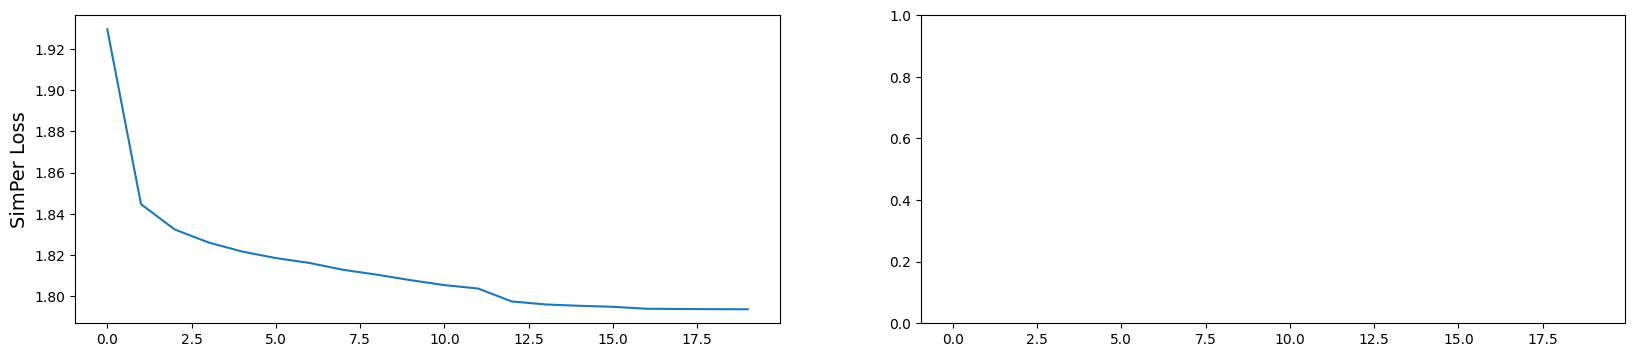

In [20]:
hparams = {'lr': 1e-3, 'label_dist_fn': 'l1', 'label_temperature': 0.1,
           'feat_dist_fn': 'batched_max_cross_corr'}
num_epochs = 20

train_loss, train_mape, test_loss, test_mape = [], [], [], []
criterion = tf.keras.losses.MeanAbsoluteError()

simper = SimPer(hparams)


# @tf.function
def train_step(loader, metrics_loss):
  for minibatch in loader:
    loss = simper.update(minibatch)
    metrics_loss.update_state(loss)

  train_loss.append(metrics_loss.result())


def lr_scheduler(base_lr, epoch, total_epoch=60):
  if epoch < 12:
    return base_lr
  if epoch < 16:
    return base_lr * 0.1
  return base_lr * 0.01


for epoch in range(num_epochs):
  metrics_train_loss = tf.keras.metrics.Mean()

  current_lr = lr_scheduler(hparams['lr'], epoch)
  tf.keras.backend.set_value(simper.optimizer.lr, current_lr)

  train_step(simper_train_loader, metrics_train_loss)

  print(f'[Epoch {epoch + 1:02d}]\t'
        f'Train Loss: {metrics_train_loss.result():.3f}')


f, ax = plt.subplots(1, 2, sharex=True, figsize=(20, 4))
ax[0].set_ylabel("SimPer Loss", fontsize=14)
ax[0].plot(train_loss)
plt.show()

#### (another example; change `hparams`) Setting: **nPSD**, **L1**

In [ ]:
hparams = {'lr': 1e-3, 'label_dist_fn': 'l1', 'label_temperature': 0.1,
           'feat_dist_fn': 'batched_normed_psd'}
num_epochs = 20

train_loss, train_mape, test_loss, test_mape = [], [], [], []
criterion = tf.keras.losses.MeanAbsoluteError()

simper = SimPer(hparams)


# @tf.function
def train_step(loader, metrics_loss):
  for minibatch in loader:
    loss = simper.update(minibatch)
    metrics_loss.update_state(loss)

  train_loss.append(metrics_loss.result())


def lr_scheduler(base_lr, epoch, total_epoch=60):
  if epoch < 12:
    return base_lr
  if epoch < 16:
    return base_lr * 0.1
  return base_lr * 0.01


for epoch in range(num_epochs):
  metrics_train_loss = tf.keras.metrics.Mean()

  current_lr = lr_scheduler(hparams['lr'], epoch)
  tf.keras.backend.set_value(simper.optimizer.lr, current_lr)

  train_step(simper_train_loader, metrics_train_loss)

  print(f'[Epoch {epoch + 1:02d}]\t'
        f'Train Loss: {metrics_train_loss.result():.3f}')


f, ax = plt.subplots(1, 2, sharex=True, figsize=(20, 4))
ax[0].set_ylabel("SimPer Loss", fontsize=14)
ax[0].plot(train_loss)
plt.show()